# Import Libraries

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from tqdm import tqdm
from model import *

In [57]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from tqdm import tqdm
!pip install torchsummary
from torchsummary import summary
import torchvision
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
#from model import *

import albumentations as A
from albumentations.pytorch import ToTensorV2

## Data Transformations




In [58]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):

    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):

        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):

        image, label = self.data[index], self.targets[index]

        if self.transform is not None:

            transformed = self.transform(image=image)

            image = transformed["image"]

        return image, label



train_transforms = A.Compose([A.HorizontalFlip(p=0.2),
                              A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.15, rotate_limit=45, p=0.2),
                              A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16,fill_value=0.4734,p=0.2),
                              A.Normalize(mean = (0.4914, 0.4822, 0.4465),std = (0.2470, 0.2435, 0.2616)),
                              ToTensorV2()])


test_transforms = A.Compose([A.Normalize(mean = (0.4914, 0.4822, 0.4465),std = (0.2470, 0.2435, 0.2616)),
                            ToTensorV2()])






# Dataset and Creating Train/Test Split

In [59]:
train = Cifar10SearchDataset(root='./data', train=True,download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,download=True, transform=test_transforms)


Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [60]:
SEED = 1

batch_size = 32

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


CUDA Available? True


shape of each image : torch.Size([3, 32, 32])


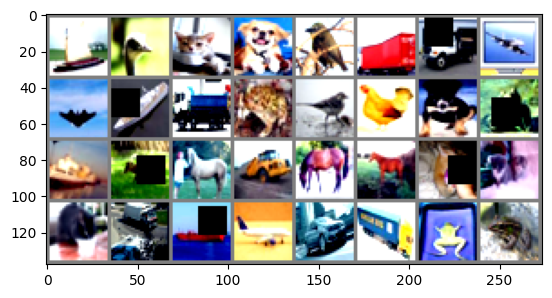

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat   cat   truck ship  plane car   truck frog  frog 


In [61]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f'shape of each image : {images[0].shape}')
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Model

In [62]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Cifar10_S9().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 16, 16]          18,432
             ReLU-10           [-1, 64, 16, 16]               0
      BatchNorm2d-11           [-1, 64, 16, 16]             128
          Dropout-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 16, 16, 16]           1,024
           Conv2d-14           [-1

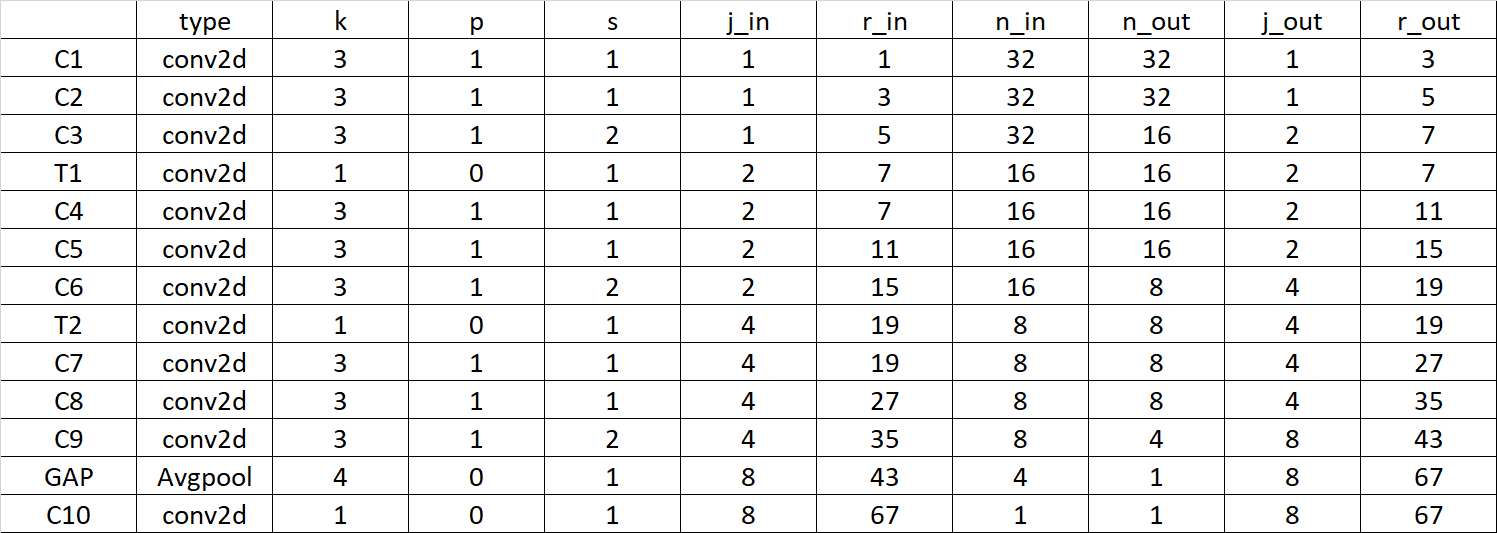

# Training and Testing

In [63]:
model =  Cifar10_S9().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=0)

In [64]:
# Data to plot accuracy and loss graphs

train_losses = []
test_losses = []
train_acc = []
test_acc = []


In [65]:
def train(model, device, train_loader, optimizer, epoch):

  model.train()

  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  epoch_loss=0


  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)


    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target, reduction='mean')


    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    epoch_loss +=loss.item()

    pbar.set_description(desc= f'Batch_id={batch_idx} Batch_Loss={loss.item():0.5f} accuracy={100*correct/processed:0.2f}')


  train_acc.append(100*correct/processed)
  epoch_loss /= len(train_loader)
  train_losses.append(epoch_loss)

  print(f'\nTrain set: Average Loss: {epoch_loss:0.4f} Accuracy : {100*correct/processed:0.2f}%')

def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_acc_ = 100. * correct / len(test_loader.dataset)
  print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(test_loader.dataset),test_acc_))

  test_acc.append(test_acc_)
  return test_loss , test_acc_

# Let's Train and test our model

In [66]:
# Custom callback class for model saving and ReduceLROnPlateau
class CustomCallback:
  def __init__(self, model):
      self.model = model
      self.best_loss = float('inf')

  def on_epoch_end(self, epoch, metric):
      # Save the model if validation loss improves
      if metric < self.best_loss:
          self.best_loss = metric
          torch.save(self.model.state_dict(), 'best_model.pth')
          print("Model saved as best_model.pth ")

      # Update the scheduler based on the validation loss
      scheduler.step(metric)

### Run for 40 epochs

In [67]:
# Train your model and update the learning rate using the scheduler
callback = CustomCallback(model)

EPOCHS = 40
for epoch in range(EPOCHS):
    print(f"EPOCH : {epoch} , lr : {optimizer.param_groups[0]['lr']}")

    train(model, device, train_loader, optimizer, epoch)
    test_loss , test_acc_ = test(model, device, test_loader)
    callback.on_epoch_end(epoch, test_loss)

EPOCH : 0 , lr : 0.01


Batch_id=1562 Batch_Loss=1.29605 accuracy=42.13: 100%|██████████| 1563/1563 [00:24<00:00, 63.98it/s]


Train set: Average Loss: 1.5802 Accuracy : 42.13%


Test set: Average loss: 1.1948, Accuracy: 5614/10000 (56.14%)

Model saved as best_model.pth 
EPOCH : 1 , lr : 0.01


Batch_id=1562 Batch_Loss=1.12809 accuracy=54.06: 100%|██████████| 1563/1563 [00:24<00:00, 63.87it/s]


Train set: Average Loss: 1.2715 Accuracy : 54.06%


Test set: Average loss: 1.0284, Accuracy: 6345/10000 (63.45%)

Model saved as best_model.pth 
EPOCH : 2 , lr : 0.01


Batch_id=1562 Batch_Loss=0.98135 accuracy=60.32: 100%|██████████| 1563/1563 [00:24<00:00, 64.57it/s]


Train set: Average Loss: 1.1174 Accuracy : 60.32%


Test set: Average loss: 0.8862, Accuracy: 6902/10000 (69.02%)

Model saved as best_model.pth 
EPOCH : 3 , lr : 0.01


Batch_id=1562 Batch_Loss=1.21107 accuracy=64.03: 100%|██████████| 1563/1563 [00:24<00:00, 63.26it/s]



Train set: Average Loss: 1.0160 Accuracy : 64.03%
Test set: Average loss: 0.7956, Accuracy: 7219/10000 (72.19%)

Model saved as best_model.pth 
EPOCH : 4 , lr : 0.01


Batch_id=1562 Batch_Loss=0.89621 accuracy=67.12: 100%|██████████| 1563/1563 [00:24<00:00, 63.09it/s]



Train set: Average Loss: 0.9387 Accuracy : 67.12%
Test set: Average loss: 0.7293, Accuracy: 7463/10000 (74.63%)

Model saved as best_model.pth 
EPOCH : 5 , lr : 0.01


Batch_id=1562 Batch_Loss=1.23238 accuracy=68.98: 100%|██████████| 1563/1563 [00:24<00:00, 63.73it/s]


Train set: Average Loss: 0.8884 Accuracy : 68.98%


Test set: Average loss: 0.6844, Accuracy: 7640/10000 (76.40%)

Model saved as best_model.pth 
EPOCH : 6 , lr : 0.01


Batch_id=1562 Batch_Loss=1.21534 accuracy=70.53: 100%|██████████| 1563/1563 [00:24<00:00, 63.42it/s]


Train set: Average Loss: 0.8501 Accuracy : 70.53%


Test set: Average loss: 0.6574, Accuracy: 7668/10000 (76.68%)

Model saved as best_model.pth 
EPOCH : 7 , lr : 0.01


Batch_id=1562 Batch_Loss=0.98719 accuracy=71.82: 100%|██████████| 1563/1563 [00:24<00:00, 62.75it/s]


Train set: Average Loss: 0.8122 Accuracy : 71.82%


Test set: Average loss: 0.6281, Accuracy: 7815/10000 (78.15%)

Model saved as best_model.pth 
EPOCH : 8 , lr : 0.01


Batch_id=1562 Batch_Loss=1.31861 accuracy=72.77: 100%|██████████| 1563/1563 [00:25<00:00, 61.50it/s]


Train set: Average Loss: 0.7836 Accuracy : 72.77%


Test set: Average loss: 0.6045, Accuracy: 7909/10000 (79.09%)

Model saved as best_model.pth 
EPOCH : 9 , lr : 0.01


Batch_id=1562 Batch_Loss=0.91979 accuracy=73.77: 100%|██████████| 1563/1563 [00:24<00:00, 63.31it/s]



Train set: Average Loss: 0.7594 Accuracy : 73.77%
Test set: Average loss: 0.5997, Accuracy: 7918/10000 (79.18%)

Model saved as best_model.pth 
EPOCH : 10 , lr : 0.01


Batch_id=1562 Batch_Loss=0.71734 accuracy=74.47: 100%|██████████| 1563/1563 [00:24<00:00, 62.95it/s]


Train set: Average Loss: 0.7356 Accuracy : 74.47%


Test set: Average loss: 0.5865, Accuracy: 8014/10000 (80.14%)

Model saved as best_model.pth 
EPOCH : 11 , lr : 0.01


Batch_id=1562 Batch_Loss=1.01699 accuracy=75.14: 100%|██████████| 1563/1563 [00:24<00:00, 64.08it/s]


Train set: Average Loss: 0.7182 Accuracy : 75.14%


Test set: Average loss: 0.5740, Accuracy: 8029/10000 (80.29%)

Model saved as best_model.pth 
EPOCH : 12 , lr : 0.01


Batch_id=1562 Batch_Loss=0.56418 accuracy=75.48: 100%|██████████| 1563/1563 [00:24<00:00, 63.18it/s]


Train set: Average Loss: 0.7003 Accuracy : 75.48%


Test set: Average loss: 0.5620, Accuracy: 8054/10000 (80.54%)

Model saved as best_model.pth 
EPOCH : 13 , lr : 0.01


Batch_id=1562 Batch_Loss=0.65316 accuracy=76.54: 100%|██████████| 1563/1563 [00:24<00:00, 62.67it/s]


Train set: Average Loss: 0.6835 Accuracy : 76.54%


Test set: Average loss: 0.5339, Accuracy: 8142/10000 (81.42%)

Model saved as best_model.pth 
EPOCH : 14 , lr : 0.01


Batch_id=1562 Batch_Loss=0.68456 accuracy=76.56: 100%|██████████| 1563/1563 [00:25<00:00, 62.45it/s]


Train set: Average Loss: 0.6777 Accuracy : 76.56%


Test set: Average loss: 0.5408, Accuracy: 8152/10000 (81.52%)

EPOCH : 15 , lr : 0.008


Batch_id=1562 Batch_Loss=0.68568 accuracy=77.85: 100%|██████████| 1563/1563 [00:24<00:00, 63.21it/s]


Train set: Average Loss: 0.6430 Accuracy : 77.85%


Test set: Average loss: 0.5220, Accuracy: 8212/10000 (82.12%)

Model saved as best_model.pth 
EPOCH : 16 , lr : 0.008


Batch_id=1562 Batch_Loss=0.54898 accuracy=78.18: 100%|██████████| 1563/1563 [00:24<00:00, 62.71it/s]


Train set: Average Loss: 0.6320 Accuracy : 78.18%


Test set: Average loss: 0.5174, Accuracy: 8213/10000 (82.13%)

Model saved as best_model.pth 
EPOCH : 17 , lr : 0.008


Batch_id=1562 Batch_Loss=0.85940 accuracy=78.48: 100%|██████████| 1563/1563 [00:25<00:00, 61.81it/s]


Train set: Average Loss: 0.6241 Accuracy : 78.48%


Test set: Average loss: 0.5081, Accuracy: 8300/10000 (83.00%)

Model saved as best_model.pth 
EPOCH : 18 , lr : 0.008


Batch_id=1562 Batch_Loss=0.79638 accuracy=78.61: 100%|██████████| 1563/1563 [00:24<00:00, 62.91it/s]


Train set: Average Loss: 0.6137 Accuracy : 78.61%


Test set: Average loss: 0.5044, Accuracy: 8259/10000 (82.59%)

Model saved as best_model.pth 
EPOCH : 19 , lr : 0.008


Batch_id=1562 Batch_Loss=1.07144 accuracy=78.92: 100%|██████████| 1563/1563 [00:25<00:00, 62.50it/s]



Train set: Average Loss: 0.6078 Accuracy : 78.92%
Test set: Average loss: 0.4973, Accuracy: 8293/10000 (82.93%)

Model saved as best_model.pth 
EPOCH : 20 , lr : 0.008


Batch_id=1562 Batch_Loss=0.80186 accuracy=79.17: 100%|██████████| 1563/1563 [00:25<00:00, 62.28it/s]



Train set: Average Loss: 0.6019 Accuracy : 79.17%
Test set: Average loss: 0.5090, Accuracy: 8272/10000 (82.72%)

EPOCH : 21 , lr : 0.0064


Batch_id=1562 Batch_Loss=0.50974 accuracy=79.96: 100%|██████████| 1563/1563 [00:25<00:00, 61.70it/s]


Train set: Average Loss: 0.5767 Accuracy : 79.96%


Test set: Average loss: 0.4785, Accuracy: 8377/10000 (83.77%)

Model saved as best_model.pth 
EPOCH : 22 , lr : 0.0064


Batch_id=1562 Batch_Loss=0.65461 accuracy=80.32: 100%|██████████| 1563/1563 [00:25<00:00, 61.74it/s]


Train set: Average Loss: 0.5651 Accuracy : 80.32%


Test set: Average loss: 0.4835, Accuracy: 8347/10000 (83.47%)

EPOCH : 23 , lr : 0.00512


Batch_id=1562 Batch_Loss=0.77284 accuracy=80.95: 100%|██████████| 1563/1563 [00:25<00:00, 61.95it/s]



Train set: Average Loss: 0.5494 Accuracy : 80.95%
Test set: Average loss: 0.4602, Accuracy: 8433/10000 (84.33%)

Model saved as best_model.pth 
EPOCH : 24 , lr : 0.00512


Batch_id=1562 Batch_Loss=0.87903 accuracy=81.34: 100%|██████████| 1563/1563 [00:25<00:00, 62.34it/s]



Train set: Average Loss: 0.5401 Accuracy : 81.34%
Test set: Average loss: 0.4594, Accuracy: 8451/10000 (84.51%)

Model saved as best_model.pth 
EPOCH : 25 , lr : 0.00512


Batch_id=1562 Batch_Loss=0.73300 accuracy=81.36: 100%|██████████| 1563/1563 [00:25<00:00, 60.18it/s]


Train set: Average Loss: 0.5396 Accuracy : 81.36%


Test set: Average loss: 0.4554, Accuracy: 8439/10000 (84.39%)

Model saved as best_model.pth 
EPOCH : 26 , lr : 0.00512


Batch_id=1562 Batch_Loss=0.58603 accuracy=81.45: 100%|██████████| 1563/1563 [00:26<00:00, 59.63it/s]


Train set: Average Loss: 0.5346 Accuracy : 81.45%


Test set: Average loss: 0.4632, Accuracy: 8434/10000 (84.34%)

EPOCH : 27 , lr : 0.004096000000000001


Batch_id=1562 Batch_Loss=0.57089 accuracy=82.05: 100%|██████████| 1563/1563 [00:26<00:00, 60.01it/s]


Train set: Average Loss: 0.5188 Accuracy : 82.05%


Test set: Average loss: 0.4599, Accuracy: 8426/10000 (84.26%)

EPOCH : 28 , lr : 0.0032768000000000007


Batch_id=1562 Batch_Loss=0.64069 accuracy=82.78: 100%|██████████| 1563/1563 [00:27<00:00, 56.21it/s]


Train set: Average Loss: 0.5029 Accuracy : 82.78%


Test set: Average loss: 0.4451, Accuracy: 8476/10000 (84.76%)

Model saved as best_model.pth 
EPOCH : 29 , lr : 0.0032768000000000007


Batch_id=1562 Batch_Loss=0.50895 accuracy=82.66: 100%|██████████| 1563/1563 [00:26<00:00, 58.24it/s]


Train set: Average Loss: 0.5024 Accuracy : 82.66%


Test set: Average loss: 0.4351, Accuracy: 8520/10000 (85.20%)

Model saved as best_model.pth 
EPOCH : 30 , lr : 0.0032768000000000007


Batch_id=1562 Batch_Loss=0.34031 accuracy=82.91: 100%|██████████| 1563/1563 [00:26<00:00, 59.71it/s]


Train set: Average Loss: 0.4963 Accuracy : 82.91%


Test set: Average loss: 0.4433, Accuracy: 8504/10000 (85.04%)

EPOCH : 31 , lr : 0.002621440000000001


Batch_id=1562 Batch_Loss=0.39836 accuracy=83.16: 100%|██████████| 1563/1563 [00:26<00:00, 59.37it/s]


Train set: Average Loss: 0.4841 Accuracy : 83.16%


Test set: Average loss: 0.4403, Accuracy: 8514/10000 (85.14%)

EPOCH : 32 , lr : 0.002097152000000001


Batch_id=1562 Batch_Loss=0.52851 accuracy=83.61: 100%|██████████| 1563/1563 [00:26<00:00, 59.53it/s]


Train set: Average Loss: 0.4839 Accuracy : 83.61%


Test set: Average loss: 0.4367, Accuracy: 8540/10000 (85.40%)

EPOCH : 33 , lr : 0.001677721600000001


Batch_id=1562 Batch_Loss=0.74656 accuracy=83.54: 100%|██████████| 1563/1563 [00:26<00:00, 58.39it/s]



Train set: Average Loss: 0.4777 Accuracy : 83.54%
Test set: Average loss: 0.4293, Accuracy: 8559/10000 (85.59%)

Model saved as best_model.pth 
EPOCH : 34 , lr : 0.001677721600000001


Batch_id=1562 Batch_Loss=0.64609 accuracy=84.10: 100%|██████████| 1563/1563 [00:27<00:00, 56.30it/s]


Train set: Average Loss: 0.4638 Accuracy : 84.10%


Test set: Average loss: 0.4295, Accuracy: 8557/10000 (85.57%)

EPOCH : 35 , lr : 0.0013421772800000008


Batch_id=1562 Batch_Loss=0.18795 accuracy=84.15: 100%|██████████| 1563/1563 [00:27<00:00, 57.83it/s]


Train set: Average Loss: 0.4617 Accuracy : 84.15%


Test set: Average loss: 0.4266, Accuracy: 8549/10000 (85.49%)

Model saved as best_model.pth 
EPOCH : 36 , lr : 0.0013421772800000008


Batch_id=1562 Batch_Loss=0.76837 accuracy=83.93: 100%|██████████| 1563/1563 [00:26<00:00, 58.56it/s]



Train set: Average Loss: 0.4658 Accuracy : 83.93%
Test set: Average loss: 0.4306, Accuracy: 8558/10000 (85.58%)

EPOCH : 37 , lr : 0.0010737418240000006


Batch_id=1562 Batch_Loss=0.30988 accuracy=84.45: 100%|██████████| 1563/1563 [00:27<00:00, 57.86it/s]



Train set: Average Loss: 0.4536 Accuracy : 84.45%
Test set: Average loss: 0.4268, Accuracy: 8575/10000 (85.75%)

EPOCH : 38 , lr : 0.0008589934592000006


Batch_id=1562 Batch_Loss=0.56581 accuracy=84.34: 100%|██████████| 1563/1563 [00:26<00:00, 58.02it/s]



Train set: Average Loss: 0.4514 Accuracy : 84.34%
Test set: Average loss: 0.4249, Accuracy: 8556/10000 (85.56%)

Model saved as best_model.pth 
EPOCH : 39 , lr : 0.0008589934592000006


Batch_id=1562 Batch_Loss=0.33425 accuracy=84.58: 100%|██████████| 1563/1563 [00:26<00:00, 59.12it/s]


Train set: Average Loss: 0.4482 Accuracy : 84.58%


Test set: Average loss: 0.4224, Accuracy: 8568/10000 (85.68%)

Model saved as best_model.pth 


Text(0.5, 1.0, 'Test Accuracy')

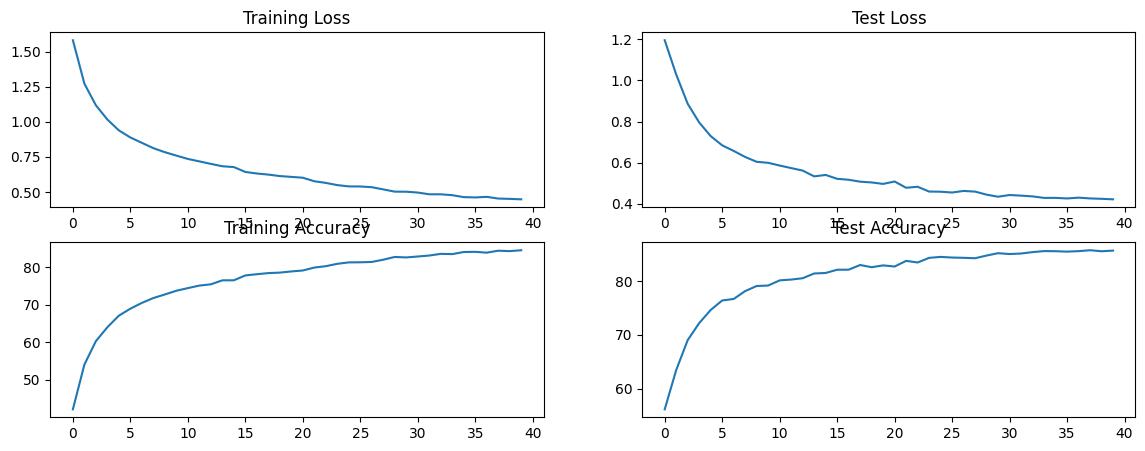

In [68]:
%matplotlib inline
fig, axs = plt.subplots(2,2,figsize=(14,5))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Incorrect predictions in test data

batch : 0 Incorrect samples : 2
Actual:['frog', 'cat']
Predicted:['cat', 'frog']


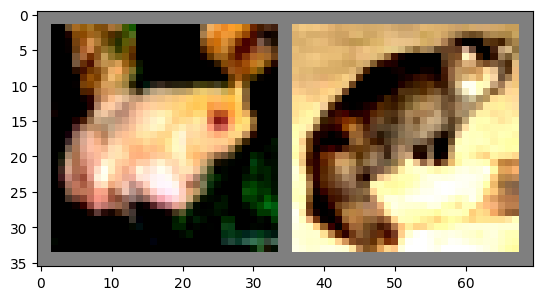

batch : 1 Incorrect samples : 4
Actual:['horse', 'cat', 'bird', 'dog']
Predicted:['deer', 'dog', 'deer', 'deer']


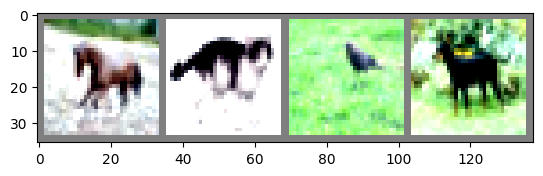

batch : 2 Incorrect samples : 3
Actual:['plane', 'plane', 'plane']
Predicted:['car', 'ship', 'truck']


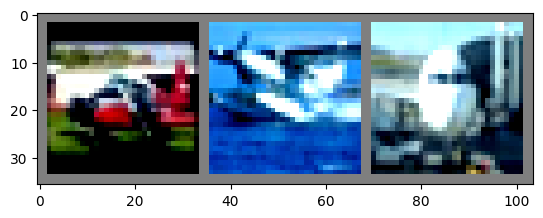

In [69]:
batch=0
with torch.no_grad():
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)

    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    non_matching_values = target[target != pred.view_as(target)]



    if len(non_matching_values)>0:
      print(f'batch : {batch} Incorrect samples : {len(non_matching_values)}')
      data, target , pred  = data.to('cpu'), target.to('cpu') , pred.to('cpu')
      print(f'Actual:{[classes[i] for i in target[target != pred.view_as(target)] ]}')
      print(f'Predicted:{[classes[i] for i in pred[target != pred.view_as(target)]]}')
      imshow(torchvision.utils.make_grid(data[target != pred.view_as(target)],nrow = 10 ))
      batch+=1


    if batch>=3:
      break